In [2]:
import pandas as pd
from sdv.metadata import SingleTableMetadata


orig_data = pd.read_csv("../data/orig_cancer_data.csv")
# metadata = SingleTableMetadata()
# metadata.detect_from_dataframe(orig_data)
# metadata.save_to_json('../data/metadata.json')
metadata = SingleTableMetadata.load_from_json('../data/metadata.json')

In [12]:
from sdv.single_table import CTGANSynthesizer


synthesizer = CTGANSynthesizer(
    metadata,
    embedding_dim=1280,
    generator_dim=(1280, 1280),
    discriminator_dim=(1280, 1280),
    generator_lr=1.5e-4,
    generator_decay=0.45e-6,
    discriminator_lr=2e-4,
    discriminator_decay=0.6e-6,
    epochs=4500,
    verbose=True,
)
synthesizer.fit(orig_data)

# synthesizer = CTGANSynthesizer.load('../models/synthesizer.pkl')

Gen. (-2.90) | Discrim. (-1.56): 100%|██████████| 4500/4500 [05:07<00:00, 14.64it/s]


<Axes: xlabel='Epoch', ylabel='Loss'>

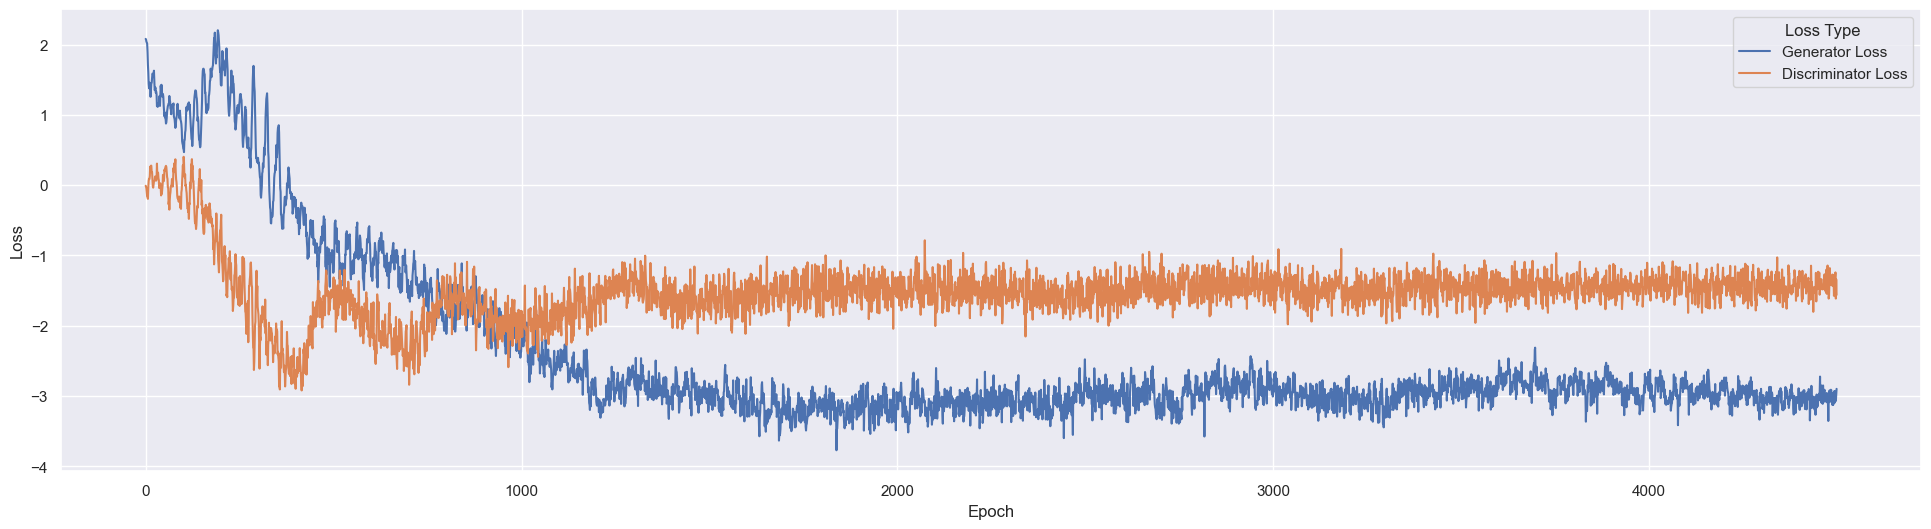

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='darkgrid')

plt.figure(figsize=(24, 6))
sns.lineplot(
    synthesizer.get_loss_values().melt(id_vars='Epoch', var_name='Loss Type', value_name='Loss'),
    x='Epoch', y='Loss',
    hue='Loss Type',
)

In [17]:
synthesizer.save('../models/synthesizer.pkl')

In [15]:
from sdv.evaluation.single_table import evaluate_quality

sample = synthesizer.sample(110000, batch_size=500)
synth_data = pd.concat([orig_data, sample], ignore_index=True).drop_duplicates()
# synth_data = pd.read_csv('../data/cancer_data.csv')
# synth_data = synthesizer.sample(1100, batch_size=500).drop_duplicates()
report = evaluate_quality(orig_data, synth_data, metadata)
synth_data.info()

Sampling rows: 100%|██████████| 110000/110000 [01:00<00:00, 1824.84it/s]


Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 24/24 [00:00<00:00, 101.79it/s]|
Column Shapes Score: 93.69%

(2/2) Evaluating Column Pair Trends: |██████████| 276/276 [00:25<00:00, 10.90it/s]|
Column Pair Trends Score: 74.58%

Overall Score (Average): 84.13%

<class 'pandas.core.frame.DataFrame'>
Index: 102440 entries, 0 to 110151
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   Age                       102440 non-null  int64 
 1   Gender                    102440 non-null  object
 2   Air Pollution             102440 non-null  int64 
 3   Alcohol Usage             102440 non-null  int64 
 4   Dust Allergy              102440 non-null  int64 
 5   Occupational Hazards      102440 non-null  int64 
 6   Genetic Risk              102440 non-null  int64 
 7   Chronic Lung Disease      102440 non-null  int64 
 8   Balanced Diet             102440 non-null  int64 
 9   Obe

In [63]:
synth_data.to_csv('../data/tmp_cancer_data.csv', index=False)